* **v1**: Introduction to SwAV pretraining.
* **v2**: I wanted to see the effect on CV with only image embedding by using ResNet pretrained with SwAV vs good-old ResNet. 

## TL;DR

Even though the top-1 accuracy of ResNet-50 is better than SwAV pre-trained ResNet-50, the CV score is ~5% better. This suggests that this method might help get a jump on the leader board.

**If you have the resources, pre-training an EfficientNet model might work better than using ArcFace loss.**

Check out the **Effect on CV Score: A Comparative Study** section below to see the details. To learn more about SwAV continue reading. 

In [ ]:
# PLEASE DON'T RUN THIS CELL NOW.
run = wandb.init(project='shopee', group='SwAV', job_type='swav_vs_supervised')

data = [['supervised', df['resnet-f1'].mean()], ['swav', df['swav-f1'].mean()]]
table = wandb.Table(data=data, columns = ["label", "value"])
wandb.log({"swav_vs_supervised" : wandb.plot.bar(table, "label", "value",
                               title="SwAV pre- vs Supervised trained ResNet-50")})
           
run.finish()
run

# Unsupervised Learning of Visual Features by Contrasting Cluster Assignments

[Paper](https://arxiv.org/abs/2006.09882) | [W&B Report](https://wandb.ai/authors/swav-tf/reports/Unsupervised-Visual-Representation-Learning-with-SwAV--VmlldzoyMjg3Mzg) | [Official PyTorch Implementation](https://github.com/facebookresearch/swav) | [Minimal TensorFlow Implementation](https://github.com/ayulockin/SwAV-TF)

## Context

Unsupervised visual representation learning is progressing at an exceptionally fast pace. Most of the modern training frameworks (SimCLR, BYOL, MoCo (V2)) in this area make use of a self-supervised model pre-trained with some contrastive learning objective. Saying these frameworks perform great w.r.t supervised model pre-training would be an understatement, as evident from the figure below - 

![img](https://i.imgur.com/TzzuGE5.png)

Figure 1: Top-1 accuracy of linear classifiers trained with the frozen features of different self-supervised methods w.r.t the fully supervised methods. ([Source](https://arxiv.org/abs/2006.09882))

Moreover, when the features learned using these different self-supervised methods are fine-tuned with as little as 1% and 10% of labeled training data show tremendous performance - 

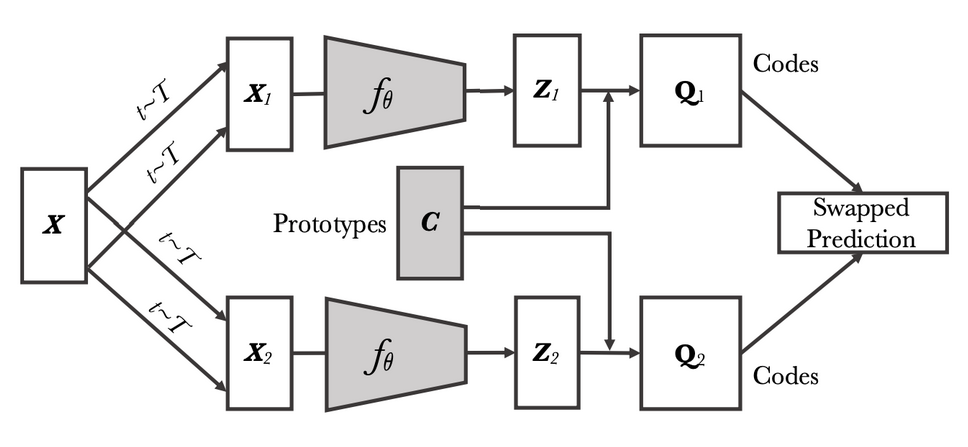

Figure 2: Performance of different semi-supervised and self-supervised frameworks on fine-tuning with very little labeled data. ([Source](https://arxiv.org/abs/2006.09882))

## How can SwAV be helpful in this competition?

Many fellow Kagglers are using pretrained image classifier with ARC Face loss function. However these image classifiers are not optimized to bring together semantically similar images in the embedding space. SwAV in my opinion can be useful and might give some gain in the LB (subject to experiments).

I along with [Sayak Paul](https://twitter.com/RisingSayak) minimally implemented this paper in TensorFlow. **This kernel is providing the same training regime for Shoppe dataset.** 

## What's SwAV?

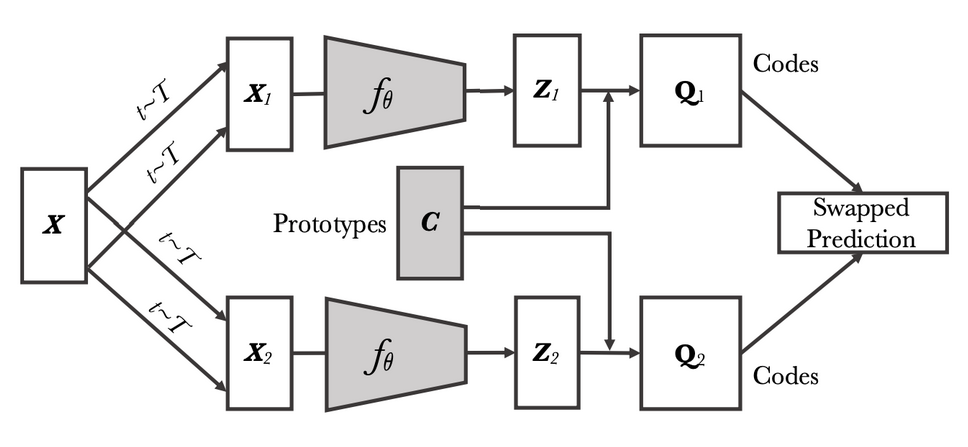

Figure 3: High-level overview of SwAV. ([Source](https://arxiv.org/abs/2006.09882))

The authors of this paper investigated a question:

> **Can we learn a meaningful metric that reflects apparent similarity among instances via pure discriminative learning?**

To answer this, they devised a novel unsupervised feature learning algorithm called instance-level discrimination. Here each image and its transformations/views are treated as two separate instances. Each image instance is treated as a separate class. The aim is to learn an embedding, mapping $x$ (image) to $v$ (feature) such that semantically similar instances(images) are closer in the embedding space.

![img](https://i.imgur.com/oRvT9wZ.gif)

## Using Weights and Biases

I have used W&B to keep track of the experiments and to save the trained models as artifacts. You will [require an account](https://wandb.ai/site) to run this kernel with W&B instrumentation. 

# Imports and Setups

In [ ]:
!git clone https://github.com/ayulockin/SwAV-TF
    
import sys
sys.path.append('SwAV-TF/utils')

In [ ]:
import multicrop_dataset
import architecture

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import os
os.environ['WANDB_SILENT'] = "true"
import gc

from itertools import groupby
from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Visit https://wandb.ai/authorize to get your API token.

In [ ]:
import wandb

wandb.login()

In [ ]:
TRAIN_PATH = '../input/shopee-product-matching/train_images/'
TRAIN_CSV = '../input/shopee-product-matching/train.csv'

In [ ]:
df = pd.read_csv(TRAIN_CSV)
images_df = df[['posting_id', 'image']]
images_df.head()

# Visualize Train Images

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def parse_data(df_dict):
    img = tf.io.read_file(TRAIN_PATH+df_dict['image'])
    img = tf.image.decode_jpeg(img, channels=3)
    image = {'image': img}
    return image

vizloader = tf.data.Dataset.from_tensor_slices(dict(images_df))

vizloader = (
    vizloader
    .map(parse_data, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [ ]:
def show_batch(image_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')
    
image_batch = []
for img in vizloader.take(25):
    image_batch.append(img['image'])

show_batch(image_batch)

# Multi Crop Resize Data Augmentation

Produces multiple views of the same image instead of just a pair of views without quadratically increasing the memory and computational requirement. More details [here](https://wandb.ai/authors/swav-tf/reports/Unsupervised-Visual-Representation-Learning-with-SwAV--VmlldzoyMjg3Mzg).

In [ ]:
# Configs
BS = 16
# Image sizes used to train the model. Use larger image size [224,96] better features.
SIZE_CROPS = [128, 96]
# Number of different augmentations of the same image
NUM_CROPS = [2, 2]
# Parameters for Random Resize Crop.
MIN_SCALE = [0.5, 0.14] 
MAX_SCALE = [1., 0.5]

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [ ]:
# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(vizloader,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

In [ ]:
# Prepare the final data loader

# Zipping 
trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

# Final trainloader
trainloaders_zipped = (
    trainloaders_zipped
    .batch(BS)
    .prefetch(AUTO)
)

im1, im2, im3, im4 = next(iter(trainloaders_zipped))
print(im1.shape, im2.shape, im3.shape, im4.shape)

# Model Architecture

In [ ]:
tf.keras.backend.clear_session()
feature_backbone = architecture.get_resnet_backbone()
feature_backbone.summary()

del feature_backbone
_ = gc.collect()

In [ ]:
tf.keras.backend.clear_session()
projection_prototype = architecture.get_projection_prototype(2048, 128, 256)
projection_prototype.summary()

del projection_prototype
_ = gc.collect()

# Sinkhorn Knopp for Cluster Assignment

Online cluster assignment and set up the swapped prediction problem. More details [here](https://wandb.ai/authors/swav-tf/reports/Unsupervised-Visual-Representation-Learning-with-SwAV--VmlldzoyMjg3Mzg).

In [ ]:
def sinkhorn(sample_prototype_batch):
    Q = tf.transpose(tf.exp(sample_prototype_batch/0.01))
    Q /= tf.keras.backend.sum(Q)
    K, B = Q.shape

    u = tf.zeros_like(K, dtype=tf.float32)
    r = tf.ones_like(K, dtype=tf.float32) / K
    c = tf.ones_like(B, dtype=tf.float32) / B

    for _ in range(3):
        u = tf.keras.backend.sum(Q, axis=1)
        Q *= tf.expand_dims((r / u), axis=1)
        Q *= tf.expand_dims(c / tf.keras.backend.sum(Q, axis=0), 0)

    final_quantity = Q / tf.keras.backend.sum(Q, axis=0, keepdims=True)
    final_quantity = tf.transpose(final_quantity)

    return final_quantity

# Train Step

In [ ]:
# @tf.function
# Reference: https://github.com/facebookresearch/swav/blob/master/main_swav.py
def train_step(input_views, feature_backbone, projection_prototype, 
               optimizer, crops_for_assign, temperature):
    # ============ retrieve input data ... ============
    im1, im2, im3, im4 = input_views 
    inputs = [im1, im2, im3, im4]
    batch_size = inputs[0].shape[0]

    # ============ create crop entries with same shape ... ============
    crop_sizes = [inp.shape[1] for inp in inputs] # list of crop size of views
    unique_consecutive_count = [len([elem for elem in g]) for _, g in groupby(crop_sizes)] # equivalent to torch.unique_consecutive
    idx_crops = tf.cumsum(unique_consecutive_count)
    
    # ============ multi-res forward passes ... ============
    start_idx = 0
    with tf.GradientTape() as tape:
        for end_idx in idx_crops:
            concat_input = tf.stop_gradient(tf.concat(inputs[start_idx:end_idx], axis=0))
            _embedding = feature_backbone(concat_input) # get embedding of same dim views together
            if start_idx == 0:
                embeddings = _embedding # for first iter
            else:
                embeddings = tf.concat((embeddings, _embedding), axis=0) # concat all the embeddings from all the views
            start_idx = end_idx
        
        projection, prototype = projection_prototype(embeddings) # get normalized projection and prototype
        projection = tf.stop_gradient(projection)

        # ============ swav loss ... ============
        # https://github.com/facebookresearch/swav/issues/19
        loss = 0
        for i, crop_id in enumerate(crops_for_assign): # crops_for_assign = [0,1]
            with tape.stop_recording():
                out = prototype[batch_size * crop_id: batch_size * (crop_id + 1)]
                
                # get assignments
                q = sinkhorn(out) # sinkhorn is used for cluster assignment
            
            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(NUM_CROPS)), crop_id): # (for rest of the portions compute p and take cross entropy with q)
                p = tf.nn.softmax(prototype[batch_size * v: batch_size * (v + 1)] / temperature) 
                subloss -= tf.math.reduce_mean(tf.math.reduce_sum(q * tf.math.log(p), axis=1))
            loss += subloss / tf.cast((tf.reduce_sum(NUM_CROPS) - 1), tf.float32)
        
        loss /= len(crops_for_assign)

    # ============ backprop ... ============
    variables = feature_backbone.trainable_variables + projection_prototype.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

# Training Loop

In [ ]:
def train_swav(feature_backbone, 
               projection_prototype, 
               dataloader, 
               optimizer, 
               crops_for_assign,
               temperature, 
               epochs=50):
  
    step_wise_loss = []
    epoch_wise_loss = []
    
    for epoch in range(epochs):
        w = projection_prototype.get_layer('prototype').get_weights()
        w = tf.transpose(w)
        w = tf.math.l2_normalize(w, axis=1)
        projection_prototype.get_layer('prototype').set_weights(tf.transpose(w))

        for step, inputs in enumerate(dataloader):
            loss = train_step(inputs, feature_backbone, projection_prototype, 
                              optimizer, crops_for_assign, temperature)

            if step%500==0:
                print(f'[{step}|{len(trainloaders_zipped)}] loss: {loss}')
            
            step_wise_loss.append(loss)
        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} epoch-wise loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))
        wandb.log({'epoch': epoch, 'loss':np.mean(step_wise_loss)})

    return epoch_wise_loss, [feature_backbone, projection_prototype]

In [ ]:
# ============ re-initialize the networks and the optimizer ... ============
tf.keras.backend.clear_session()
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(dense_2=128, prototype_dimension=256)

decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

# ================= initialize wandb ======================
run = wandb.init(project='shopee', group='SwAV', job_type='train')

# ======================= train  ===========================
epoch_wise_loss, models = train_swav(feature_backbone, 
    projection_prototype, 
    trainloaders_zipped, 
    opt,
    crops_for_assign=[0, 1],
    temperature=0.1, 
    epochs=10
)

run.finish()
run

# Save the trained weights as W&B Artifacts

In [ ]:
# Serialize the models
feature_backbone, projection_prototype = models
feature_backbone.save_weights('feature_backbone_10_epochs.h5')
projection_prototype.save_weights('projection_prototype_10_epochs.h5')

In [ ]:
run = wandb.init(project='shopee', group='SwAV', job_type='artifacts')
artifact = wandb.Artifact('swav-model', type='model')
artifact.add_file('feature_backbone_10_epochs.h5')
artifact.add_file('projection_prototype_10_epochs.h5')
run.log_artifact(artifact)
run.finish()

## Disclaimer/Notes

* It might happen that you run out of RAM while running this Kernel. You might want to lower the resolution of the cropped images by changing this parameter `SIZE_CROPS`, you can also change the number of views generated by changing this `NUM_CROPS`. Note that GPU is not going to be an issue in the default configuration.
* I have trained this model on a GCP instance and I have saved the weights of the same as W&B artifacts. To download the weigths use the code snippet below:

```
import wandb
run = wandb.init()
artifact = run.use_artifact('ayush-thakur/shopee/swav-model:v0', type='model')
artifact_dir = artifact.download()
```

* This is a minimal implementation of the technique. Fortunately the authors of the SwAV paper have provided us with the pretrained weights. To use it,

```
import torch
model = torch.hub.load('facebookresearch/swav', 'resnet50')
```

Finally if you like the work consider upvoting the kernel and would appreciate a star for our [GitHub repo](https://github.com/ayulockin/SwAV-TF).

# Effect on CV Score: A Comparative Study

### Imports

In [ ]:
import cv2
import torch
from torch import nn
import torch.nn.functional as F 
import torchvision.models as models
from torch.utils.data import Dataset 

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2


import gc
import cudf
import cuml
import cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

def seed_torch(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch()

### Configurations

In [ ]:
class CFG:
    img_size = 512
    batch_size = 12
    seed = 2020
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = 11014
    
    scale = 30 
    margin = 0.5

### Data Loader

In [ ]:
def read_dataset():
    # Read CSV file.
    df = pd.read_csv('../input/shopee-product-matching/train.csv')
    df_cu = cudf.DataFrame(df)
    image_paths = '../input/shopee-product-matching/train_images/' + df['image']
    return df, df_cu, image_paths

In [ ]:
def get_test_transforms():
    # Transformations.
    return A.Compose(
        [
            A.Resize(CFG.img_size,CFG.img_size,always_apply=True),
            A.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

class ShopeeDataset(Dataset):
    '''
    Dataloader
    '''
    def __init__(self, image_paths, transforms=None):

        self.image_paths = image_paths
        self.augmentations = transforms

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image

### Get Predictions

In [ ]:
def get_image_predictions(df, embeddings,threshold = 3.4):
    # Get predictions using KNN.
    if len(df) > 3:
        KNN = 50
    else : 
        KNN = 3
    
    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in tqdm(range(embeddings.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return predictions

### Generate Image Embeddings

In [ ]:
def get_image_embeddings(image_paths, model):
    embeds = []
    
    model.eval()
    model = model.to(CFG.device)

    image_dataset = ShopeeDataset(image_paths=image_paths,transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=CFG.batch_size,
        pin_memory=True,
        drop_last=False,
        num_workers=4
    )
    
    with torch.no_grad():
        for img in tqdm(image_loader): 
            img = img.cuda()
            feat = model(img)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    
    del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

### Models

The comparative study is between ResNet-50 trained using conventional image-classification method vs ResNet-50 pre-trained using SwAV. 

**Note**: The supervised counterpart has better Top-1 accuracy metric. It would be interesting to see if SwAV training methodology of cluster assignment is improving the CV score or not. 

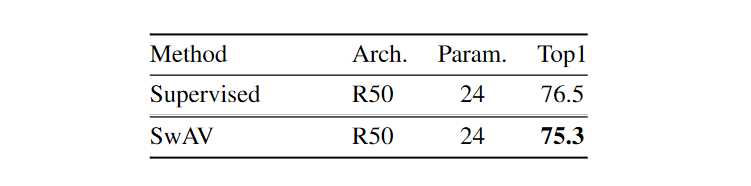

In [ ]:
class ResNet50Embedding(nn.Module):
    def __init__(self, original_model):
        super(ResNet50Embedding, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x

# Load model
model_resnet_swav = torch.hub.load('facebookresearch/swav', 'resnet50')
model_resnet = models.resnet50(pretrained=True)
    
# Get output at Global Average Pooling.
model_resnet_swav = ResNet50Embedding(model_resnet_swav).to(device)
model_resnet = ResNet50Embedding(model_resnet).to(device)

### Read Data, Get Image Embeddings, And Get Predictions

In [ ]:
df, df_cu, image_paths = read_dataset()
df.head()

In [ ]:
# Get embeddings using SwAV-ResNet
image_embeddings_swav = get_image_embeddings(image_paths.values, model_resnet_swav)
image_embeddings_swav = image_embeddings_swav.reshape((34250, 2048))

# Get embeddings uing Supervised-ResNet
image_embeddings_sup = get_image_embeddings(image_paths.values, model_resnet)
image_embeddings_sup = image_embeddings_sup.reshape((34250, 2048))

In [ ]:
# Get image similarity predictions using SwAV embeddings 
image_predictions_swav = get_image_predictions(df, image_embeddings_swav, threshold = 1.7)

# Get image similarity predictions using Supervised embeddings
image_predictions_sup = get_image_predictions(df, image_embeddings_sup, threshold = 1.7)

### Compute CV Score

In [ ]:
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)
print('train shape is', df.shape )
df.head()

In [ ]:
# Ref: https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

In [ ]:
df['image_predictions_swav'] = image_predictions_swav
df['image_predictions_sup'] = image_predictions_sup

df.head()

In [ ]:
df['swav-f1'] = df.apply(getMetric('image_predictions_swav'),axis=1)
df['resnet-f1'] = df.apply(getMetric('image_predictions_sup'),axis=1)

In [ ]:
run = wandb.init(project='shopee', group='SwAV', job_type='swav_vs_supervised')

data = [['supervised', df['resnet-f1'].mean()], ['swav', df['swav-f1'].mean()]]
table = wandb.Table(data=data, columns = ["label", "value"])
wandb.log({"swav_vs_supervised" : wandb.plot.bar(table, "label", "value",
                               title="SwAV pre- vs Supervised trained ResNet-50")})
           
run.finish()
run

That's amazing! Even though the top-1 accuracy of ResNet-50 is better than SwAV pre-trained ResNet-50, the CV score is ~5% better. This suggests that this method might help get a jump on the leader board.

If you have the resources, pre-training an EfficientNet model might work better than using ArcFace loss. 

Hope you find it useful.